# Assignment 2 - Choice of Algorithm

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from scipy.stats.mstats import winsorize
import math
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import shap
import datetime
import warnings
warnings.filterwarnings('ignore')

## Preparation (20 points)

*5 points for correct preprocessing*

*5 points for splitting train- and test set*

*10 points for correct implementation of stationarity adjustment(s)*

----
This assignment focusses on which algorithms to implement, and how to compare and value them. The goal is to write a short report for a hedge fund manager who's looking into the gold market. Up until now, the hedgefund uses the following AR(1) model to predict gold prices.

AR(1) model:
$y_t = \mu + \phi y_{t - 1} + \epsilon_t$

Hand in a PDF file of 1 page containing the results of your analysis including recommendation(s). In addition, hand in the code and answers in the notebook.

Download the dataset from <a href="https://www.kaggle.com/datasets/hemil26/gold-rates-1985-jan-2022?select=daily_gold_rate.csv">kaggle</a>, pick one of the currencies as Y (to be predicted) and make it into weekly average rates. Download the datasets from 
<a href="https://fred.stlouisfed.org/series/WCURCIR">here,</a>
<a href="https://fred.stlouisfed.org/series/WRESBAL">here</a>
<a href="https://fred.stlouisfed.org/series/WTREGEN">and here</a>
as X (regressors). Make sure all of the dates line up, so there's no mix-up.

First, the data has to be preprocessed. Take a good look at the data and check for NaN's, as these are the most important parts in time series preprocessing.

An important thing to keep in mind in the case of a time series is stationarity. Test for it, and adjust the data if necessary.

# ANSWERS
## Preparation

<div style="font-size:16px; text-align:center; font-weight:bold">Preprocessing</div>

Below is the short summmary of the preprocessing steps:
1. Downloading 4 csv-files with `Y` and `X` variables;
2. Checking for non-numeric values;
3. Merging all prepared weekly data ensuring that the data is merged on `Date`, thus avoiding null values;
4. Checking our time series for stationarity graphically and confirming our non-stationarity assumptions with the help of Augmented Dickey-Fuller test. Getting rid of stationarity.
5. Split data in train and test sets. More about it in section **Splitting data into training and test sets**.


Step 1:

Our output variable `Y` represents weekly average gold prices denominated in US Dollars. The input variables `X` are monetary data of the U.S. Federal Reserve denominated in Billions of US Dollars:
- Currency in Circulation: Week Average (WCURCIR), 
- Reserve Balances with Federal Reserve Banks: Week Average (WRESBAL), 
- U.S. Treasury, General Account: Week Average (WTREGEN) 

Step 2:

We analyse average weekly data over the period **08-01-1986 (Jan 8, 1986) - 24-08-2022 (Aug 24, 2022)** after accounting for some missing values in all csv datasets. In total, we have 1,912 weekly observations.

Step 3:

The gold price data is merged with the independent variables on the week number and the year. Because the three csv files with independent variables are set on each Wednesday, we use the corresponding dates when presenting the final dataframe containing all analyzed information. 

Step 4:

The resulting dataframe `df` containing 1,912 observations contains gold price information and the absolute values of the above mentioned monetary variables. Because of that, we assume the stationarity problem inherent to such type of data. 

Because the hedge fund manager is using AR(1) model to predict gold prices, We first look at the ACF and PACF autoregression plots for this variable (denoted as `USD`). Figure 0A and 0B show that while PACF drops immediately after lag 2, ACF doesn't demonstrate exponential decay as implied by AR models. Moreover, we see that ACF stays the same, which indicates the presense of unit root, or non-stationarity, in the data.

Because the presense of non-stationarity causes spurious forecasts, it's best to avoid it for the subsequent analysis. More about dealing with stationarity in section **Dealing with non-stationarity**. After that, we end up with a set of 1,911 observations and the analyzed period starts from **15-01-1986** because we drop NaN values corresponding to the first observation.


In [75]:
# Reading csv and preparing dataframme for output variable Y
df = pd.read_csv('daily_gold_rate.csv', sep = ',')
df['Date']= pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Choose USD to predict
df = pd.DataFrame(df['USD'])

In [76]:
# Setting our output variable dataframe on weekly basis
df['Year'] = df.index.isocalendar().year
df['WeekNum'] = df.index.isocalendar().week
df = df.groupby(['Year', 'WeekNum']).mean()
df = df.reset_index()
df['WeekDate'] = pd.to_datetime(df['Year'].astype(str) + df['WeekNum'].astype(str) + "3", format='%G%V%w')
df = df.drop(columns=['Year', 'WeekNum'])
df = df.set_index('WeekDate')

In [77]:
# Reading csv and preparing dataframe for X-variable CURRENCY IN CIRCULATION
cir = pd.read_csv('WCURCIR.csv', sep = ',')
cir['DATE']= pd.to_datetime(cir['DATE'])
cir = cir.set_index('DATE')
cir = pd.DataFrame(cir)

In [78]:
# Reading csv and preparing dataframe for X-variable RESERVE BALANCE
rb = pd.read_csv('WRESBAL.csv', sep = ',')
rb['DATE']= pd.to_datetime(rb['DATE'])
rb = rb.set_index('DATE')
rb = pd.DataFrame(rb)

In [79]:
# Reading csv and preparing dataframe for X-variable GENERAL ACCOUNT
ga = pd.read_csv('WTREGEN.csv', sep = ',')
ga['DATE']= pd.to_datetime(ga['DATE'])
ga = ga.set_index('DATE')
ga = pd.DataFrame(ga)

In [80]:
# Checking for NAN values
print(df.isna().sum())
print(df.isnull().sum())
print(cir.isna().sum())
print(cir.isnull().sum())
print(rb.isna().sum())
print(rb.isnull().sum())
print(ga.isna().sum())
print(ga.isnull().sum())

USD    0
dtype: int64
USD    0
dtype: int64
WCURCIR    0
dtype: int64
WCURCIR    0
dtype: int64
WRESBAL    0
dtype: int64
WRESBAL    0
dtype: int64
WTREGEN    0
dtype: int64
WTREGEN    0
dtype: int64


In [81]:
# Merging prepared dataframes into one
cir_rb = pd.merge(cir,rb,left_on="DATE",right_on="DATE")
cir_rb_ga = pd.merge(cir_rb,ga,left_on="DATE",right_on="DATE")
df = pd.merge(df, cir_rb_ga,left_on=df.index.strftime("%Y-%m-%d %H:%M:%S"),right_on=cir_rb_ga.index.strftime("%Y-%m-%d %H:%M:%S"))
df = df.rename(columns={'key_0': 'Date'})
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')
df = df.set_index('Date')
df

USD   WCURCIR   WRESBAL  WTREGEN
Date                                            
1986-01-08   332.91   196.332    27.558    4.140
1986-01-15   348.55   194.014    29.218    5.032
1986-01-22   352.96   192.377    25.966   13.856
1986-01-29   354.63   190.854    23.461   17.487
1986-02-05   339.50   190.607    24.463   12.475
...             ...       ...       ...      ...
2022-07-27  1731.98  2274.452  3256.875  602.945
2022-08-03  1773.97  2274.415  3259.011  594.115
2022-08-10  1792.63  2275.554  3348.147  557.265
2022-08-17  1766.99  2275.881  3346.750  545.321
2022-08-24  1746.05  2275.453  3307.365  535.267

[1912 rows x 4 columns]

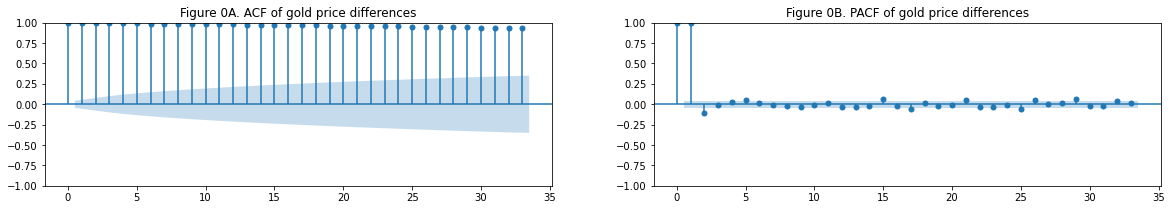

In [82]:
fig, ax = plt.subplots(1,2,figsize=(20,3))
plot_acf(df.USD, ax = ax[0], title="Figure 0A. ACF of gold price differences")
plot_pacf(df.USD, ax = ax[1], title="Figure 0B. PACF of gold price differences")
plt.show()

<a id='stationarity'></a>
 <div style="font-size:16px; text-align:center; font-weight:bold">Dealing with non-stationarity.</div>

The Augmented Dickey-Fuller Test is used to test for a unit root in a univariate process in the presence of autocorrelations. Because our output and input variables represent time series data, we want to have it tested for non-stationarity. For the purposes of the analysis, we want to avoid using non-stationary data as the subsequent analysis will produce spurious results and poor predictions. $H_{0}$ and $H_{A}$ hypotheses as per below were tested for both output and input variables: 

$H_{0}$: The data is not stationary 

$H_{A}$: The data is stationary

The ADF tests for all 4 variables showed that there's a unit root in the gold prices `USD`, as well as 2 independent variables `WCURCIR` and `WRESBAL`. The t-statistic for the variable `WTREGEN` was insignificant allowing us to accept the null hypothesis about non-stationarity, however, we can see from Figure 1 that after 2008, the data explodes in a stochastic trend.

Considering the above, we decide to proceed with the analysis using first order differences. Figure 2A and 2B confirm that stationarity is no longer a problem with (partial) autocorrelation = 0 after lag1.

In [83]:
# Define a function for ADF test
def adfullertest(X):
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
	    print('\t%s: %.3f' % (key, value))

In [84]:
# Apply the function for each variable in our dataframe
for i in range(0, len(df.columns)):
    print(df.columns[i])
    adfullertest(df.iloc[:, i].values)

USD
ADF Statistic: 0.104963
p-value: 0.966398
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
WCURCIR
ADF Statistic: 3.815667
p-value: 1.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
WRESBAL
ADF Statistic: -0.538053
p-value: 0.884374
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
WTREGEN
ADF Statistic: -4.204306
p-value: 0.000648
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [85]:
df_delta = df.copy()
df_delta["USD_d"] = df_delta["USD"].diff(1)
df_delta["WCURCIR_d"] = df_delta["WCURCIR"].diff(1)
df_delta["WRESBAL_d"] = df_delta["WRESBAL"].diff(1)
df_delta["WTREGEN_d"] = df_delta["WTREGEN"].diff(1)
df_delta = df_delta.dropna()
df_delta = df_delta.drop(columns = ['USD', 'WCURCIR', 'WRESBAL', 'WTREGEN'])
df_delta

USD_d  WCURCIR_d  WRESBAL_d  WTREGEN_d
Date                                              
1986-01-15  15.64     -2.318      1.660      0.892
1986-01-22   4.41     -1.637     -3.252      8.824
1986-01-29   1.67     -1.523     -2.505      3.631
1986-02-05 -15.13     -0.247      1.002     -5.012
1986-02-12  -3.79      0.667     -1.026     -5.621
...           ...        ...        ...        ...
2022-07-27  15.29     -2.345    -27.449    -10.933
2022-08-03  41.99     -0.037      2.136     -8.830
2022-08-10  18.66      1.139     89.136    -36.850
2022-08-17 -25.64      0.327     -1.397    -11.944
2022-08-24 -20.94     -0.428    -39.385    -10.054

[1911 rows x 4 columns]

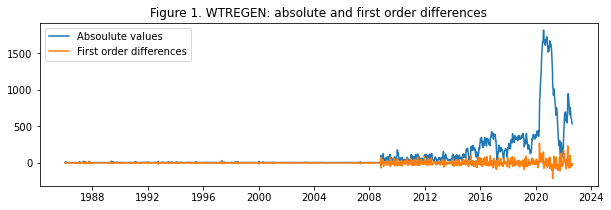

In [86]:
fig = plt.figure(figsize=(10,3))
plt.title("Figure 1. WTREGEN: absolute and first order differences")
plt.plot(df["WTREGEN"], label = "Absoulute values")
plt.plot(df_delta["WTREGEN_d"], label = "First order differences")
plt.legend();

It can be concluded that there is no non-stationary problem in our dataset that is composed of the first order differences. After lag 2, there are no autocorrelation and partial autocorrelation left in the USD_d data.

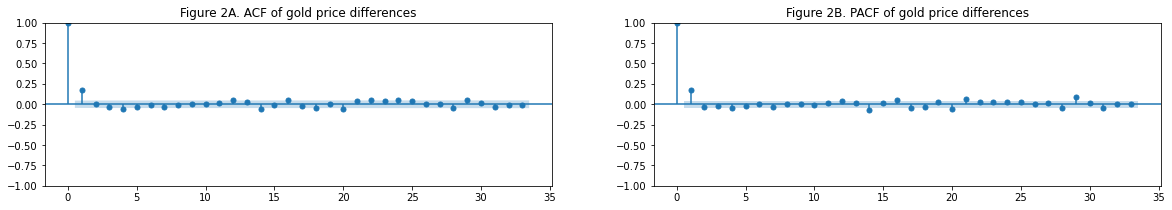

In [87]:
fig, ax = plt.subplots(1,2,figsize=(20,3))
plot_acf(df_delta.USD_d, ax = ax[0], title="Figure 2A. ACF of gold price differences")
plot_pacf(df_delta.USD_d, ax = ax[1], title="Figure 2B. PACF of gold price differences")
plt.show()

<div style="font-size:16px; text-align:center; font-weight:bold">Splitting data into training and test sets.</div>

As per the assignment requirement, we split our dataset into training (in-sample) and test (out-of-sample) sets in the following way:
- Training set: 15-01-1986 - 29-12-2021
- Test set: 01-01-2022 - 24-08-2022 (the last available date in our dataset)

Splitting data randomly as per Assignment 1 is not logical since we have time series data.

After that, we run AR(1) model to later compare it with the performance of regression models with the same train / test split. As evident from the `AutoReg` output and Figure 3, the autoregressive model is not suitable for predicting gold prices. The forecast essentially produces a horizontal line converging immediately around 0. Therefore, we conclude that AR(1) model is not the best for predicting first order differences.

In [88]:
# Separating data into in-sample and out-of-sample for AR
in_sample = pd.DataFrame(df_delta['USD_d'].loc[df_delta.index.isocalendar().year < 2022])
out_sample = pd.DataFrame(df_delta['USD_d'].loc[df_delta.index.isocalendar().year >= 2022])
in_sample.tail()

# Separating data into training and test set for Regressions
train_set = pd.DataFrame(df_delta.loc[df_delta.index.isocalendar().year < 2022])
test_set = pd.DataFrame(df_delta.loc[df_delta.index.isocalendar().year >= 2022])


In [89]:
ar_model = AutoReg(in_sample, lags=1).fit()
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                  USD_d   No. Observations:                 1877
Model:                     AutoReg(1)   Log Likelihood               -7980.608
Method:               Conditional MLE   S.D. of innovations             17.032
Date:                Mon, 28 Nov 2022   AIC                          15967.215
Time:                        15:36:56   BIC                          15983.826
Sample:                    01-22-1986   HQIC                         15973.334
                         - 12-29-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6365      0.394      1.617      0.106      -0.135       1.408
USD_d.L1       0.1778      0.023      7.829      0.000       0.133       0.222
                                    Roots           

In [90]:
prediction = ar_model.predict(start = len(in_sample), end = (len(df_delta)-1), dynamic=False)

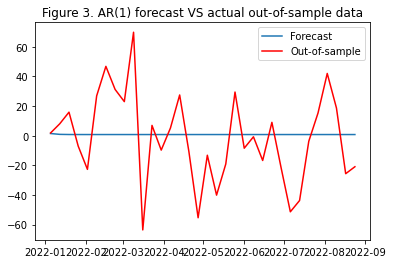

In [91]:
pyplot.plot(prediction, label = "Forecast")
pyplot.plot(out_sample, color='red', label = "Out-of-sample")
plt.title("Figure 3. AR(1) forecast VS actual out-of-sample data")
plt.legend();

## Algorithm Selection (40 points)


*10 points for correct code*

*10 points for right metric useage and hyperparameter conclusions*

*10 points for the application of PCA and the interpretation of its performance*

*10 points for giving the (dis)advantages*

----
We seperate a training and test set in order to make predictions on the available 2022 data, i.e. the test set should cover 01/01/2022 - 26/08/2022. Use all of the algorithms in the following selection: Decision Tree Regressor, AdaBoost Regressor and a Multi-Layered Perceptron Regressor (MLP). Train the algorithms on the training set and make predictions on the test set. Use the Mean Absolute Error (MAE) and the Root Mean Squared Error (RMSE) to see how the models perform, and to tune the hyperparameters. Also, use Shapley values to try to explain the output of the ML models, and comment on the results and the choice for the plot with the Shapley values.

For each of the algorithms used, give an advantage **or** a disadvantage for using it in a time series scenario in comparison with a regular AR(1) model.

Use PCA to reduce the dimensionality of the regressors, apply the transformed data to see if it increases performance and comment on the results.

# ANSWERS

<div style="font-size:16px; text-align:center; font-weight:bold">Decision Tree Regressor</div>

A decision tree is a supervised machine learning algorithm that constructs a set of decisions based on training data and tries to predict a meaningful continuous output.

#### Avantages of Decision Tree Regression for predicting gold prices

- Unlike other ML algorithms, decision tree doesn't require normalization; the analysis can be done without scaling the data:
- It is not largely influenced by outliers (and in case of our data, we have quite a lot of outliers)

#### Disadvantages of Decision Tree Regression for predicting gold prices

- Overfitting in aiming to reduce the error of the train data at the cost of the error of test data. To avoid, setting parameter constraints is required;
- Can be computationally costly if complex.

#### Model evaluation
 To see how this models perform in comparison with others, we will use following metrics:
- Mean Absolute Error (MAE) 
- Root Mean Squared Error (RMSE)
Using the metrics above, we will identify the most optimal number of hyperparameters.

Upon the first run of the regression before hyperparameter tuning, we get the following results:
- MAE = 33.83
- RMSE = 40.09

 At first glance (Figure 5), we may assume that our model doesn't perform very well.

#### Hyperparameter tuning
Because GridSearchCV method requires too much computational power when all hyperparameters are being found at once, we decided to use an incremental approach to hyperparameter tuning. We are going to twitch three hyperparameters - `max_depth`, `min_samples_leaf`, and `max_leaf_modes`. We identify that:
- setting maximum depth = 14 (`Figure 5B`) 
- minimum number of samples per leaf = 16 (`Figure 5C`) and
- maximum number of leaf nodes = 24 (`Figure 5D`)
produces the best results. 

As a result of the hyperparamter tuning for our Decision Tree Regression, the errors dropped as follows:
- MAE: 33.83 -> 21.85
- MRSE: 40.09 -> 26.60

MAE: 33.8323529411765
RMSE: 40.08701073180396


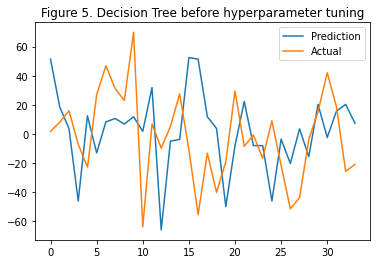

In [92]:
# Separating regressors from output variable
X_train = train_set.drop(columns = "USD_d")
Y_train = train_set.drop(train_set.columns[1:4], axis = 1)

X_test = test_set.drop(columns = "USD_d")
Y_test = test_set.drop(test_set.columns[1:4], axis = 1)

dt_regressor = DecisionTreeRegressor(random_state = 42)
dt_regressor.fit(X_train, Y_train)

y_pred = dt_regressor.predict(X_test)

# Function to output results
def show_model_results(y_prediction, y_actual, x_actual, plot_name = ""):
    #First visualise
    plt.title(plot_name)
    plt.plot(y_prediction, label = "Prediction")
    plt.plot(y_actual.to_numpy(), label = "Actual")
    plt.legend();

    #Show metrics
    print("MAE: %s" %mean_absolute_error(y_prediction, y_actual))
    print("RMSE: %s" %mean_squared_error(y_prediction, y_actual, squared=False))

show_model_results(y_pred, Y_test, X_test, plot_name="Figure 5. Decision Tree before hyperparameter tuning")

In [93]:
# Checking for hyperparameter min_samples_leaf
# wrap in a reusable function
def dt_tune_min_sample_leaf(x_train, y_train, x_test, y_test):
    mae = []
    rmse = []
    leafs = []

    for i in range (5,21):
        # Run decision tree regression with new hyperparams and see the metrics
        tuned_dt_regressor = DecisionTreeRegressor(min_samples_leaf=i, random_state=42)
        #train
        tuned_dt_regressor.fit(x_train, y_train)

        #prediction
        y_pred_tuned = tuned_dt_regressor.predict(x_test)
        mae.append(mean_absolute_error(y_pred_tuned, y_test))
        rmse.append(mean_squared_error(y_pred_tuned, y_test, squared=False))
        leafs.append(i)

    plt.plot(leafs,rmse)
    plt.title("Figure 5B. RMSE vs. Min_samples_leaf ");

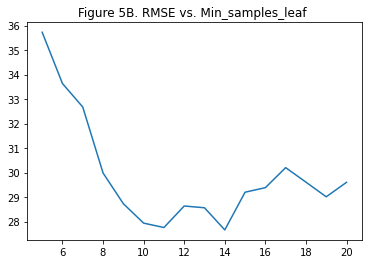

In [94]:
dt_tune_min_sample_leaf(X_train, Y_train, X_test, Y_test)

In [95]:
def dt_tune_max_depth(x_train, y_train, x_test, y_test, min_leaf):
    mae = []
    rmse = []
    depths = []

    for i in range (5,21):
        # Run decision tree regression with new hyperparams and see the metrics
        tuned_dt_regressor = DecisionTreeRegressor(min_samples_leaf=min_leaf, max_depth=i, random_state=42)
        #train
        tuned_dt_regressor.fit(x_train, y_train)

        #prediction
        y_pred_tuned = tuned_dt_regressor.predict(x_test)
        mae.append(mean_absolute_error(y_pred_tuned, y_test))
        rmse.append(mean_squared_error(y_pred_tuned, y_test, squared=False))
        depths.append(i)
    plt.plot(depths,rmse)
    plt.title("Figure 5C. RMSE vs. max_depth");

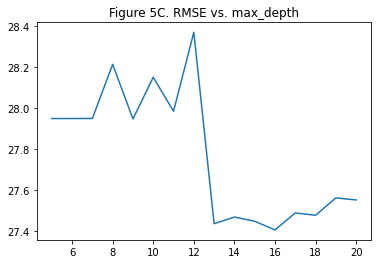

In [96]:
dt_tune_max_depth(X_train, Y_train,X_test, Y_test, 14)

In [97]:
def dt_tune_max_leaf_nodes(x_train, y_train, x_test, y_test, min_leaf, depth):
    mae = []
    rmse = []
    nodes = []

    for i in range (10,50):
        # Run decision tree regression with new hyperparams and see the metrics
        tuned_dt_regressor = DecisionTreeRegressor(min_samples_leaf=min_leaf, max_depth=depth, max_leaf_nodes=i, random_state=42)
        #train
        tuned_dt_regressor.fit(x_train, y_train)

        #prediction
        y_pred_tuned = tuned_dt_regressor.predict(x_test)
        mae.append(mean_absolute_error(y_pred_tuned, y_test))
        rmse.append(mean_squared_error(y_pred_tuned, y_test, squared=False))
        nodes.append(i)
    plt.plot(nodes,rmse)
    plt.title("Figure 5D. RMSE vs. max_nodes");

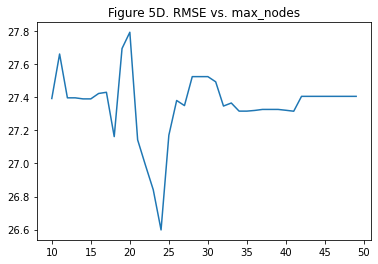

In [98]:
dt_tune_max_leaf_nodes(X_train, Y_train, X_test, Y_test, 14, 16)

MAE: 21.85438843975255
RMSE: 26.598403600216066


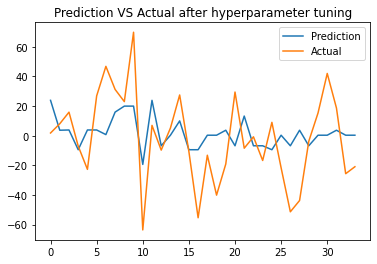

In [99]:
dt_final_model = DecisionTreeRegressor(min_samples_leaf=14, max_depth=16, max_leaf_nodes=24,random_state=42)
tuned_dt_regressor = dt_final_model.fit(X_train, Y_train)
y_pred_tuned = tuned_dt_regressor.predict(X_test)
show_model_results(y_pred_tuned, Y_test, X_test, plot_name="Prediction VS Actual after hyperparameter tuning")

<div style="font-size:16px; text-align:center; font-weight:bold">AdaBoost Regressor</div>

Adaboost is an ensemble learning model which can increase the efficiency. It's also called a "boosting algorithm" that ensembles learning algorithms that create a weak learner, which is boosted by improved weights, and create a final model with more predictive power. 

#### Advantages of AdaBoost Regression for predicting gold prices
- Because it's a sequential algorithm, it may have a stronger predictive power since every next model is dependent on the results of previously implemented models;
- Less prone to overfitting as opposed to Decision Tree Regression since the  input parameters are not jointly optimized;

It might be argued that it is better than decision tree approach since there is an adjustment before coming up with the final model. Also, there is literature that discusses the topics of Adaboost algorithm to be used in time series forecasting which is an another indication that it might be an advantage to use since we know that academic papers affects corporate decisions.

#### Disadvantages of AdaBoost Regression for predicting gold prices
- Prone to noisy data and outliers (which is definitely our case).

#### Model Evaluation
One of AdaBoost Regression's hyperparameters is base estimator from which the boosted ensemble is built. The default base estimator is `DecisionTreeRegressor` initialized with max_depth=3. 
Upon comparing the AdaBoost performance with this default parameter and the tuned parameters as per the previous analysis, we identified that with the tuned base estimator AdaBoost Regression performs better:
- MAE 21.73 (versus 23.96 with default parameters) 
- RSME 27.77 (versis 30.33 with default parameters)
(see Figure 6A and 6B)

As we can see, the AdaBoost Regression performed better than the Decision Tree Regression before tuning. The subsequent hyperparameter tuning will seek to identify if the model can be further optimized.

#### Hyperparameter tuning
AdaBoost Regressor has a few important hyperparameters that play a great role in predicting and training a model. They are:
- `n_estimator` (the number of decision stumps)
- `learning_rate`, 
- `loss`

By tuning them incrementally we identify the most optimal values for the above mentioned hyperparameters that produce MAE value of 21.73 and the value of RSME is equal to 28.12:

- `n_estimator` = 40 (Figure 6C)
- `learning_rate`= 4.5 
- `loss` = exponential

Figure 6D shows the performance of tuned AdaBoost regression as opposed to the actual prices.

MAE: 23.962198219169107
RMSE: 30.325524563621133


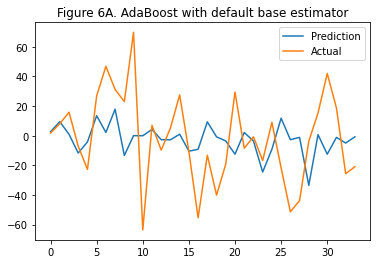

In [100]:
ada_default_model = AdaBoostRegressor(n_estimators=100, random_state=42)
ada_reg_df = ada_default_model.fit(X_train, Y_train)
ypred_ada_df = ada_reg_df.predict(X_test)
show_model_results(ypred_ada_df, Y_test, X_test)
plt.title("Figure 6A. AdaBoost with default base estimator");

In [101]:
#AdaBoost with a a tuned Decision Tree with min_samples_leaf=14, max_depth=13, max_leaf_nodes=2
ada_dt_tuned_model = AdaBoostRegressor(dt_final_model, n_estimators=100, random_state=42)
ada_reg = ada_dt_tuned_model.fit(X_train, Y_train)
ypred_ada = ada_reg.predict(X_test)

MAE: 21.731354266949648
RMSE: 27.767553546918606


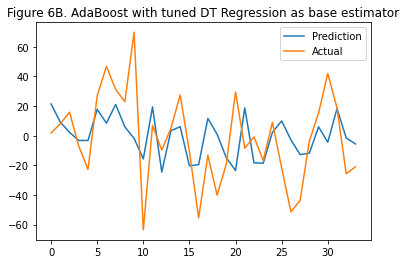

In [102]:
show_model_results(ypred_ada, Y_test, X_test, "Adaboost Regression")
plt.title("Figure 6B. AdaBoost with tuned DT Regression as base estimator");

In [103]:
# Checking for hyperparameter n_estimator
def ada_tune_estimator(x_train, y_train, x_test, y_test, base_estimator):
    mae = []
    rmse = []
    combined = []

    for i in range (10,100, 10):
        # Run AdaBoost with new hyperparams and see the metrics
        ada_reg_tuned = AdaBoostRegressor(base_estimator, n_estimators=i, random_state=42)
        ada_reg_tuned.fit(x_train, y_train)

        #prediction
        ypred_tuned = ada_reg_tuned.predict(x_test)

        mae = mean_absolute_error(ypred_tuned, y_test)
        rmse = mean_squared_error(ypred_tuned, y_test, squared=False)
        combined.append([i, rmse, mae])
    plt.plot(pd.DataFrame(combined).iloc[:, 0].values,pd.DataFrame(combined).iloc[:, 1].values)

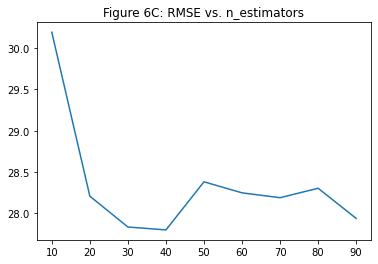

In [104]:
ada_tune_estimator(X_train, Y_train, X_test, Y_test, dt_final_model)
plt.title("Figure 6C: RMSE vs. n_estimators");

After our initial estimator calculation, we run the algorithm again with the resulted estimator. However, adding other hyperparameters might change this result. We look at whether selecting different learning rate or loss function will reduce RSME even further.

In [105]:
# Now let's check the remaning two hyperparameters by checking all combinations within our defined range and output the final model
def ada_tune_loss_lrate(x_train, y_train, x_test, y_test, base_estimator, n_est):
    loss = ['linear', 'square', 'exponential']
    combined = []

    for loss in loss:
        for j in np.arange(0.5, 10.02, 0.5):
            ada_reg_tuned = AdaBoostRegressor(base_estimator, n_estimators=n_est, learning_rate=j, loss = loss, random_state=42).fit(x_train, y_train)

            ypred_tuned = ada_reg_tuned.predict(x_test)

            mae = mean_absolute_error(ypred_tuned, y_test)
            rmse = mean_squared_error(ypred_tuned, y_test, squared=False)
            combined.append([j, loss, rmse, mae])

            min_rsme = pd.DataFrame(combined).loc[pd.DataFrame(combined).iloc[:, 3] == min(pd.DataFrame(combined).iloc[:, 3])]
            learnrate_calculated = float(min_rsme.iloc[:, 0].loc[min_rsme.index == min_rsme.index[0]].values)
            loss_calculated = str(min_rsme.iloc[:, 1].loc[min_rsme.index == min_rsme.index[0]].values[0])
            ada_reg_min_rsme = AdaBoostRegressor(tuned_dt_regressor, n_estimators=80, loss = loss_calculated, learning_rate=learnrate_calculated, random_state=42).fit(x_train, y_train)
            ypred_min_rsme = ada_reg_min_rsme.predict(x_test)
    print (learnrate_calculated, loss_calculated)
    show_model_results(ypred_min_rsme, y_test, x_test, "Adaboost Regression - Estimator with min RSME")

4.5 exponential
MAE: 21.73512079748381
RMSE: 28.116077654884606


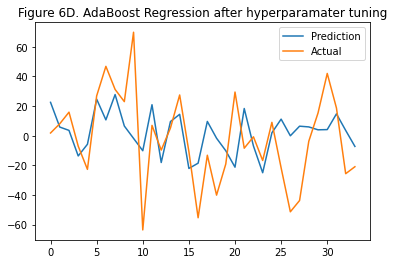

In [106]:
ada_tune_loss_lrate(X_train, Y_train, X_test, Y_test, dt_final_model, 40)
plt.title("Figure 6D. AdaBoost Regression after hyperparamater tuning");

<div style="font-size:16px; text-align:center; font-weight:bold">Multi-Layered Perceptron Regressor (MLP)</div>

A multilayer perceptron is a class of feedforward artificial neural network. It is characterized by several layers of input nodes connected as a directed graph between the input and output layers. MLP uses backpropogation for training the network.

First, we train an MLP model with default parameters which doesn't produce good results. It's evident that hyperparameter tuning is needed. Moreover, we see that the prediction series is much flatter than the actual one, although the magnitude of error is not that big. We assume this happens because our data is not normalized / standardized. We will check this assumption in the last step of this question.

#### Advantages of MLP for predicting gold prices
- Unlike traditional models used for time series regression analysis (e.g. ARIMA), MLP can handle missing values and non-linear relathionships as well as supports multiple inputs.

#### Disadvantages of MLP for predicting gold prices
- Sensitive to standardization and scaling (before standardizing / normalizing the data, the model may perform worse compared to the counterparts);
- Computationally complex and time consuming;
- Too many hyperparamaters.

#### Model evaluation

As for Decistion Tree and AdaBoost regressions, we will use MAE and RMSE metrics to evaluate the performance of MLP. Upon training with the following set of hyperameters:
- `hidden_layer_size = (50,50,50)`
- `activation = relu`
- `solver = adam`
- `max_iter = 5000`
- `early_stopping = True`

the results are as follows (Figure 7A): 
- MAE: 23.97
- RMSE: 30.25

#### Hyperparameter tuning

Since there are so many hyperparameters such as number of hidden layers, how may units in each of these hidden layers, learning rate, activation function, number of epochs etc., we cannot look at them in a timely manner. Therefore, we first change each hyperparameter manually to see which play a role in reducing the error. For example, we discovered that the `max_iter` parameter doesn't affect the error of the model. We also make assumptions for some of the hyperparameters:

- In our MLPRegressor, we will use 2 hidden layers. For each layer, we will check the number of units increasing by 50 each time. 
- Also, we will select max 5000 epochs, and if the model is not improving, in order to stop the process we will use early stopping. 
- We will work with `adam` solver and `relu` activation function

The hyperparameter tuning for MLP showed the following results:
- MAE: 23.97 --> 23.43
- RMSE: 30.25 --> 29.55

In [107]:
mlp_base = MLPRegressor(hidden_layer_sizes=(50,50,50), activation="relu", solver="adam", max_iter = 5000, early_stopping=True, random_state = 42)
mlp_reg = mlp_base.fit(X_train, Y_train)

y_pred_mlp = mlp_reg.predict(X_test)

MAE: 23.970432003125705
RMSE: 30.248381123115383


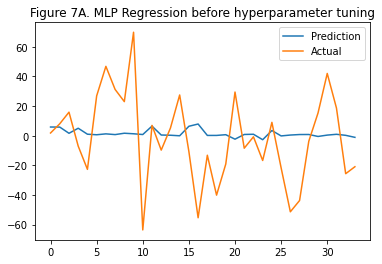

In [108]:
show_model_results(y_pred_mlp, Y_test, X_test, "Figure 7A. MLP Regression before hyperparameter tuning")

In [109]:
def mlp_tune_layers(x_train, y_train, x_test, y_test):
    mlp = []

    for k in range(50, 202, 50):
        for j in range(50, 202, 50):
            for i in range(50, 202, 50):
                mlp_reg_tuned = MLPRegressor(
                    hidden_layer_sizes=(j,k,i), 
                    activation="relu", 
                    solver="adam", 
                    max_iter = 5000, 
                    early_stopping=True, 
                    random_state = 42).fit(x_train, y_train)

                y_pred_tuned = mlp_reg_tuned.predict(x_test)
                mae = mean_absolute_error(y_pred_tuned, y_test)
                rsme = mean_squared_error(y_pred_tuned, y_test, squared=False)
                mlp.append([i, j, k, rsme, mae])

                min_rsme = pd.DataFrame(mlp).loc[pd.DataFrame(mlp).iloc[:, 3] == np.min(pd.DataFrame(mlp).iloc[:, 3])]

                hiddenlayer1 = int(min_rsme.iloc[:, 0].loc[min_rsme.index == min_rsme.index[0]].values)
                hiddenlayer2 = int(min_rsme.iloc[:, 1].loc[min_rsme.index == min_rsme.index[0]].values)
                hiddenlayer3 = int(min_rsme.iloc[:, 2].loc[min_rsme.index == min_rsme.index[0]].values)

                mlp_reg_min_rsme = MLPRegressor(hidden_layer_sizes=(hiddenlayer1,hiddenlayer2, hiddenlayer3), activation="relu", solver="adam", max_iter = 5000, early_stopping=True, random_state = 42).fit(x_train, y_train)
                y_pred_min_rsme = mlp_reg_min_rsme.predict(x_test)

    show_model_results(y_pred_min_rsme, y_test, x_test, "Figure 7B. MLP Regression after hyperparameter tuning")

MAE: 23.43009711720659
RMSE: 29.550749685266435


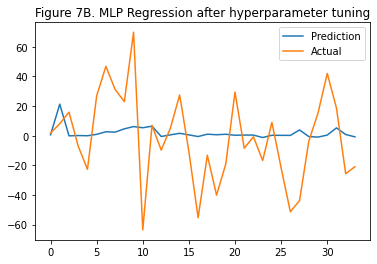

In [110]:
mlp_tune_layers(X_train, Y_train, X_test, Y_test)

<div style="font-size:16px; text-align:center; font-weight:bold">Principal  Components Analysis (PCA)</div>

PCA is a method of compressing a lot of data into something that captures the essense of original data. Principal components (PCs) are central to PCA as they capture the most variation between observations. By doing so, PCA suggests that the least variation is not meaningful to analyzing the data. 
For our dataset, the first two principal components ($PC_{1}$ amd $PC_{2}$) capture 99.9% of all variations. We decide to run another iteration of hyperparameter tuning with transformed variables to see if PCA improves the performance of our models.

#### Hyperparameter tuning 
Below is the summary of MAE and RMSE metrics for all three regressions

#### Decision Tree Regression
|  | Model training - pre-PCA     | Tuned - pre-PCA | Model training - post-PCA      | Tuned  post-PCA |
| ---- | ----------- | ----------- |-------------|-------------|
| MAE| 34.99      | 22.06       |34.26      | 22.79       |
| RMSE | 41.013      | 26.74       |42.55      | 29.13       |

#### AdaBoost Regression
|  | Model training - pre-PCA     | Tuned - pre-PCA | Model training - post-PCA      | Tuned  post-PCA |
| ---- | ----------- | ----------- |-------------|-------------|
| MAE| 23.96      | 21.73       |24.06      | 24.71       |
| RMSE | 30.36      | 28.13       |29.68      | 30.97       |

#### MLP Regression
|  | Model training - pre-PCA     | Tuned - pre-PCA | Model training - post-PCA      | Tuned  post-PCA |
| ---- | ----------- | ----------- |-------------|-------------|
| MAE| 24.15      | 23.43       | 23.66     | 24.87      |
| RMSE | 30.26      | 29.55       | 29.11     | 31.45       |


As evident from the summary of metrics above, PCA did not significantly improve the predictions for all three models. In fact, MAE and RMSE are slightly higher after PCA. The possible explanation for this could be that PCA is a **linear** regularizer, while the relationships between our output variable and the regressors seem to be non-linear. 

In [111]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [112]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.77653675, 0.21922517, 0.00423808])

It can be seen that the information is captured by the first two principal components. Because together they cause over the 99% variance in the dataset. So we will use these first two components.

In [113]:
pca_transformation = PCA(n_components=2)
X_train_transformed = pca_transformation.fit_transform(X_train)
X_test_transformed = pca_transformation.transform(X_test)

#### Below we repeat the same hyperparameter tuning procedure, but after PCA
DecisionTree Regressor - PCA Transformed

MAE: 34.25529411764704
RMSE: 42.55164032229125


Text(0.5, 1.0, 'Figure 8A. Decision Tree training after PCA')

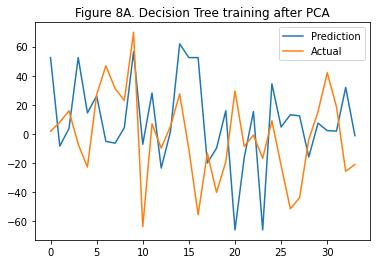

In [114]:
dt_regressor.fit(X_train_transformed, Y_train)
y_pred_dt_pca1 = dt_regressor.predict(X_test_transformed)
show_model_results(y_pred_dt_pca1, Y_test, X_test_transformed)
plt.title("Figure 8A. Decision Tree training after PCA")

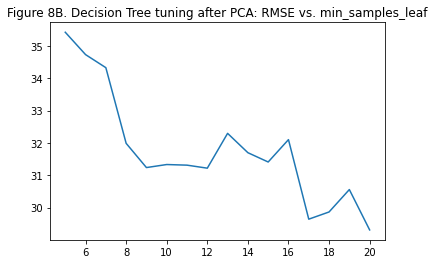

In [115]:
dt_tune_min_sample_leaf(X_train_transformed, Y_train, X_test_transformed, Y_test)
plt.title("Figure 8B. Decision Tree tuning after PCA: RMSE vs. min_samples_leaf");

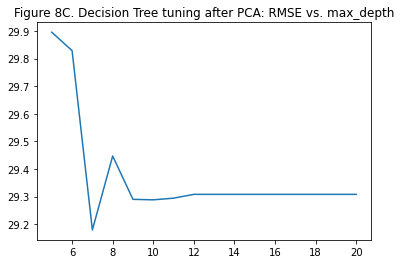

In [116]:
dt_tune_max_depth(X_train_transformed, Y_train, X_test_transformed, Y_test, 20)
plt.title("Figure 8C. Decision Tree tuning after PCA: RMSE vs. max_depth");

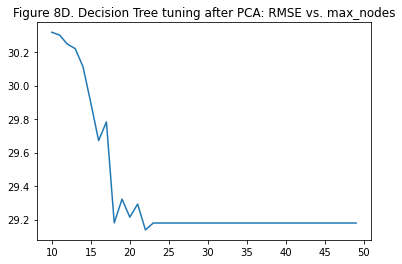

In [117]:
dt_tune_max_leaf_nodes(X_train_transformed, Y_train, X_test_transformed, Y_test, 20, 7)
plt.title("Figure 8D. Decision Tree tuning after PCA: RMSE vs. max_nodes");

MAE: 22.797588454811336
RMSE: 29.13827588357538


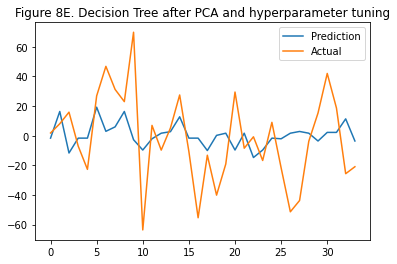

In [118]:
dt_final_model_pca = DecisionTreeRegressor(min_samples_leaf=20, max_depth=7, max_leaf_nodes=22,random_state=42).fit(X_train_transformed, Y_train)
y_pred_dt_pca_tuned = dt_final_model_pca.predict(X_test_transformed)
show_model_results(y_pred_dt_pca_tuned, Y_test, X_test_transformed)
plt.title("Figure 8E. Decision Tree after PCA and hyperparameter tuning");

Adaboost Regression - PCA Transformed

In [119]:
ada_reg_pca = AdaBoostRegressor(dt_final_model_pca,random_state=42).fit(X_train_transformed, Y_train)
ypred2 = ada_reg_pca.predict(X_test_transformed)

MAE: 24.061452326763042
RMSE: 29.681046630689398


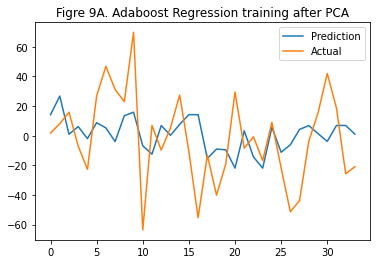

In [120]:
show_model_results(ypred2, Y_test, X_test_transformed, "Figre 9A. Adaboost Regression training after PCA")

Text(0.5, 1.0, 'Figure 9B. AdaBoost tuning: RMSE vs. n_estimators - after PCA')

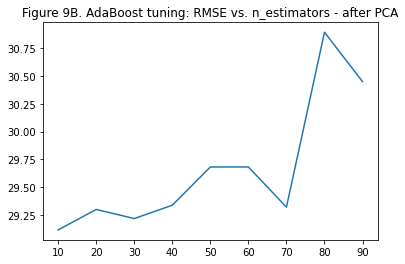

In [121]:
ada_tune_estimator(X_train_transformed, Y_train, X_test_transformed, Y_test, dt_final_model_pca)
plt.title("Figure 9B. AdaBoost tuning: RMSE vs. n_estimators - after PCA")

2.0 linear
MAE: 24.718119540458954
RMSE: 30.969228917072346


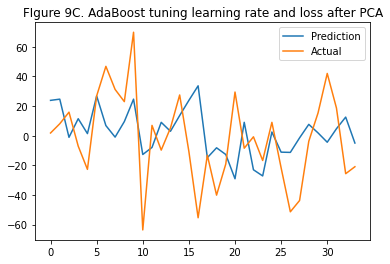

In [122]:
ada_tune_loss_lrate(X_train_transformed, Y_train, X_test_transformed, Y_test, dt_final_model_pca, 10)
plt.title("FIgure 9C. AdaBoost tuning learning rate and loss after PCA");

MLP - PCA Transformed

MAE: 23.660236572175798
RMSE: 30.11093869987092


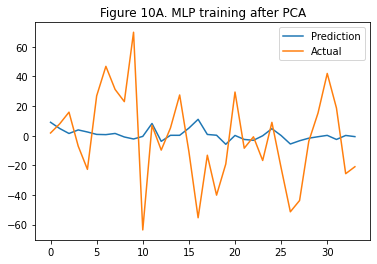

In [123]:
mlp_base_pca = MLPRegressor(hidden_layer_sizes=(50,50), activation="relu", solver="adam", max_iter = 5000, early_stopping=True, random_state = 42)
mlp_reg_pca = mlp_base_pca.fit(X_train_transformed, Y_train)

y_pred_mlp = mlp_reg_pca.predict(X_test_transformed)

show_model_results(y_pred_mlp, Y_test, X_test)
plt.title("Figure 10A. MLP training after PCA");

MAE: 24.8774184785964
RMSE: 31.457569980939805


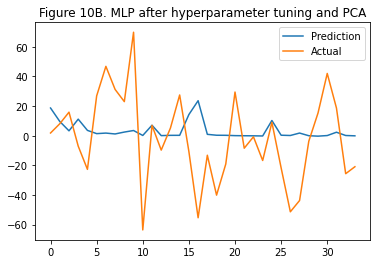

In [124]:
mlp_tune_layers(X_train_transformed, Y_train, X_test_transformed, Y_test)
plt.title("Figure 10B. MLP after hyperparameter tuning and PCA");

<div style="font-size:16px; text-align:center; font-weight:bold">Normalization</div>

For some algorithms, it is recommended to use feature normalization and/or standardizations ensuring that the data are on the same scale. Of the 3 algorithms examined in this assignmemt, MLP is the one that most surely requires some sort of scaling. This could be the reason why it has performed the worst so far.
Decision Tree based algorithms (Decision Tree and AdaBoost) are known to be less sensitive to scaling, but we will re-iterate the procedures from the previous steps on normalized data.

#### Model evaluations on normalized data
Below is the comparison of the three models performance on normalized data.

<b>NOTE: Tuned post-PCA part did not improve our results significantly. Moreover, the total runtime for the whole jupyter notebook was over 5 minutes. Therefore, the results are included in the table but the corresponding code removed from submission since it is also basically the same process before normalisation PCA analysis.</b>

#### Decision Tree Regression
|  | Model training - pre-PCA     | Tuned - pre-PCA | Model training - post-PCA      | Tuned  post-PCA |
| ---- | ----------- | ----------- |-------------|-------------|
| MAE| 0.124      | 0.081       |0.097      | 0.088       |
| RMSE | 0.147      | 0.098       |0.125      | 0.108       |

#### AdaBoost Regression
|  | Model training - pre-PCA     | Tuned - pre-PCA | Model training - post-PCA      | Tuned  post-PCA |
| ---- | ----------- | ----------- |-------------|-------------|
| MAE| 0.086      | 0.076       |0.086      | 0.083       |
| RMSE | 0.109      | 0.098       |0.106      | 0.104       |

#### MLP Regression
|  | Model training - pre-PCA     | Tuned - pre-PCA | Model training - post-PCA      | Tuned  post-PCA |
| ---- | ----------- | ----------- |-------------|-------------|
| MAE| 0.092      | 0.089       | 0.087     | 0.088      |
| RMSE | 0.114      | 0.111       | 0.109     | 0.111       |

In [125]:
df_delta_normalized = df_delta.copy()
df_delta_normalized.head()

USD_d  WCURCIR_d  WRESBAL_d  WTREGEN_d
Date                                              
1986-01-15  15.64     -2.318      1.660      0.892
1986-01-22   4.41     -1.637     -3.252      8.824
1986-01-29   1.67     -1.523     -2.505      3.631
1986-02-05 -15.13     -0.247      1.002     -5.012
1986-02-12  -3.79      0.667     -1.026     -5.621

In [126]:
for i in range(0, len(df_delta_normalized.columns)):
    column = df_delta_normalized.iloc[:, i].values
    normalised = preprocessing.MinMaxScaler()
    column_normalised = normalised.fit_transform(column.reshape(-1, 1))
    df_delta_normalized.iloc[:, i] = column_normalised

df_delta_normalized.head()

USD_d  WCURCIR_d  WRESBAL_d  WTREGEN_d
Date                                                 
1986-01-15  0.691235   0.410099   0.477496   0.441673
1986-01-22  0.649932   0.421589   0.470207   0.458172
1986-01-29  0.639854   0.423512   0.471316   0.447370
1986-02-05  0.578065   0.445041   0.476520   0.429392
1986-02-12  0.619773   0.460461   0.473510   0.428126

Train test split after normalization

In [127]:
train_set_normalized = pd.DataFrame(df_delta_normalized.loc[df_delta_normalized.index.isocalendar().year < 2022])
test_set_normalized = pd.DataFrame(df_delta_normalized.loc[df_delta_normalized.index.isocalendar().year >= 2022])

X_train_normalized = train_set_normalized.drop(columns = "USD_d")
Y_train_normalized = train_set_normalized.drop(train_set_normalized.columns[1:4], axis = 1)

X_test_normalized = test_set_normalized.drop(columns = "USD_d")
Y_test_normalized = test_set_normalized.drop(test_set_normalized.columns[1:4], axis = 1)

DecisionTree Regressor After Normalization

MAE: 0.12387470711555076
RMSE: 0.14725841491105085


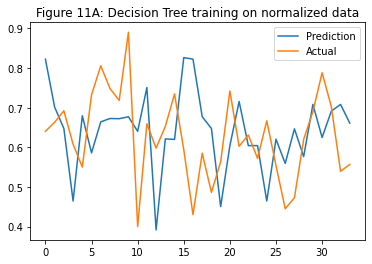

In [128]:
dt_regressor_norm = DecisionTreeRegressor(random_state = 42)
dt_regressor_norm.fit(X_train_normalized, Y_train_normalized)

y_pred_norm = dt_regressor_norm.predict(X_test_normalized)

show_model_results(y_pred_norm, Y_test_normalized, X_test_normalized, plot_name="Figure 11A: Decision Tree training on normalized data")

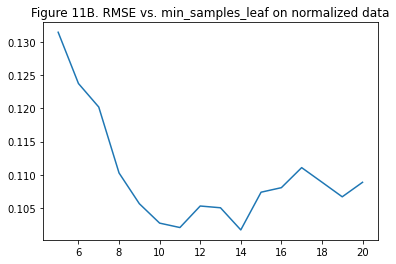

In [129]:
dt_tune_min_sample_leaf(X_train_normalized, Y_train_normalized, X_test_normalized, Y_test_normalized)
plt.title("Figure 11B. RMSE vs. min_samples_leaf on normalized data");

Text(0.5, 1.0, 'Figure 11C. RMSE vs. max_depth on normalized data')

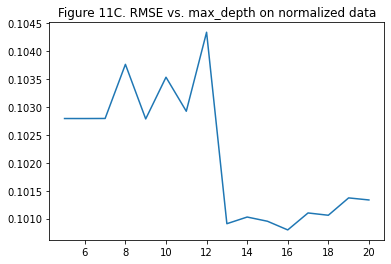

In [130]:
dt_tune_max_depth(X_train_normalized, Y_train_normalized, X_test_normalized, Y_test_normalized, 14)
plt.title("Figure 11C. RMSE vs. max_depth on normalized data")

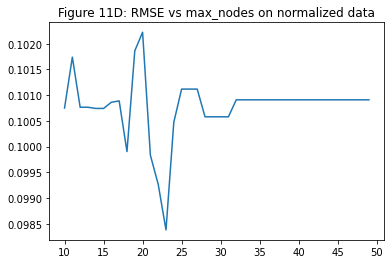

In [131]:
dt_tune_max_leaf_nodes(X_train_normalized, Y_train_normalized, X_test_normalized, Y_test_normalized, 14, 13)
plt.title("Figure 11D: RMSE vs max_nodes on normalized data");

MAE: 0.08115801367899994
RMSE: 0.09837890473467516


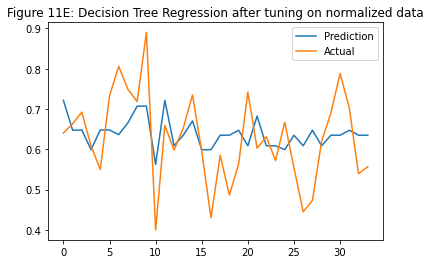

In [132]:
dt_final_model_norm = DecisionTreeRegressor(min_samples_leaf=14, max_depth=13, max_leaf_nodes=23,random_state=42)
tuned_dt_regressor_norm = dt_final_model_norm.fit(X_train_normalized, Y_train_normalized)
y_pred_tuned_norm = tuned_dt_regressor_norm.predict(X_test_normalized)
show_model_results(y_pred_tuned_norm, Y_test_normalized, X_test_normalized, plot_name="Figure 11E: Decision Tree Regression after tuning on normalized data")

AdaBoost Regressor After Normalization

MAE: 0.07731416494796468
RMSE: 0.09944647120339886


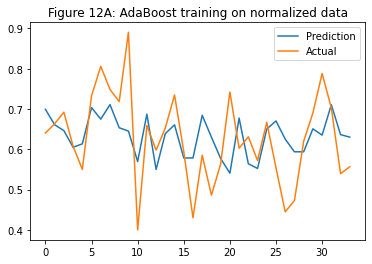

In [133]:
#AdaBoost with a a tuned Decision Tree with min_samples_leaf=14, max_depth=13, max_leaf_nodes=2
ada_dt_tuned_model_norm = AdaBoostRegressor(tuned_dt_regressor_norm, n_estimators=100, random_state=42)
ada_reg_norm = ada_dt_tuned_model_norm.fit(X_train_normalized, Y_train_normalized)
ypred_ada_norm = ada_reg_norm.predict(X_test_normalized)

show_model_results(ypred_ada_norm, Y_test_normalized, X_test_normalized, "Figure 12A: AdaBoost training on normalized data")

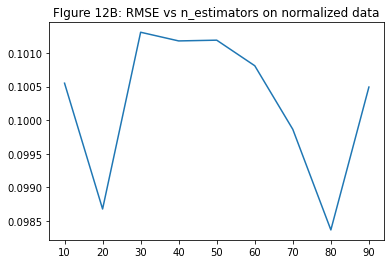

In [134]:
ada_tune_estimator(X_train_normalized, Y_train_normalized, X_test_normalized, Y_test_normalized, tuned_dt_regressor_norm)
plt.title("FIgure 12B: RMSE vs n_estimators on normalized data");

1.0 linear
MAE: 0.08014214800069316
RMSE: 0.10260201362693883


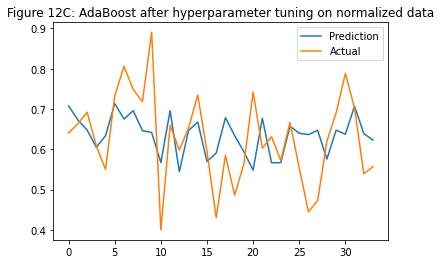

In [135]:
ada_tune_loss_lrate(X_train_normalized, Y_train_normalized, X_test_normalized, Y_test_normalized, tuned_dt_regressor_norm, 80)
plt.title("Figure 12C: AdaBoost after hyperparameter tuning on normalized data");

MLP After Normalization

Here, we chose 2 hidden layers as through multiple iterations we figured out it produces the lowest error.

MAE: 0.09218188746974065
RMSE: 0.11484981645692838


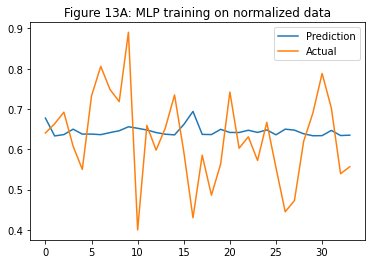

In [136]:
mlp_base_norm = MLPRegressor(hidden_layer_sizes=(50,50), activation="relu", solver="adam", max_iter = 5000, early_stopping=True, random_state = 42)
mlp_reg_norm = mlp_base_norm.fit(X_train_normalized, Y_train_normalized)

y_pred_mlp_norm = mlp_reg_norm.predict(X_test_normalized)

show_model_results(y_pred_mlp_norm, Y_test_normalized, X_test_normalized, "Figure 13A: MLP training on normalized data")

MAE: 0.08931806735862735
RMSE: 0.11172478083525045


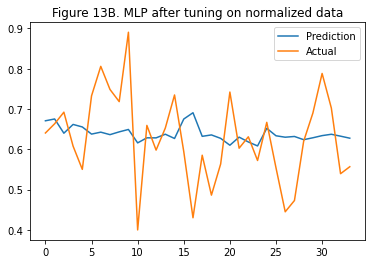

In [137]:
mlp_tune_layers(X_train_normalized, Y_train_normalized, X_test_normalized, Y_test_normalized)
plt.title("Figure 13B. MLP after tuning on normalized data");

<div style="font-size:16px; text-align:center; font-weight:bold">Shapley Analysis</div>

Shapley Analysis is used to explain the effect of features on the predicted outcome. It can help us understand black-box models' decisions, that is, it can tell us which features affect the output of the models and in what direction.

In classification problems, positive SHAP values mean positive impact on prediction, leadning the model to predict 1(e.g. TEST PASSED), while negative lead the model to predict 0 (e.g. TEST NOT PASSED). In regression problems, like our case, we can interpret SHAP values as the input contribution to predictions. 

We performed our analysis as follows:
- Calculated Shapley summary plots for Decision Tree Regression models for training and test sets separately;
- Calculated Shapley summary plots for AdaBoost and MLP Regression models for test sets.

Key takeaways: 
- Train and test sets are completely different, which could be confirmed by the value each of the 3 features have on the predicted output. When we look at the force plot of features on individual output, we can also see that for obeservation t = 666 from the train data set, the effect of features is different compared to observation t = 25 from the test data set;

- We can make an overal conclusion with regards to the "direction" of the effect of each feature. For example, the variable `WTREGEN_d` General Account has mostly negative Shapley values for all three regression algortihms;

- Shapley values vary depending on algortihms.

Shapley values are also useful when explaining the results of each particular instance. For example, the analysis below shows that for observation t = 666 of the train data, the variable WRESBAL_d, representing the first differences of weekly average Reserve balances, has positive effect on the Decision Tree model output whereas the other two have negative effect. Our base value is 0.7834 whereas the output value is lower - 0.32. The blue lines in the plot below show which features cause reduced predictions. Meanwhile, the variable representing Currency in Circulation `WCURCIR_d` has the most impact on the predictions (-0.410). 

In [138]:
shap.initjs()

SHAP Summary plot

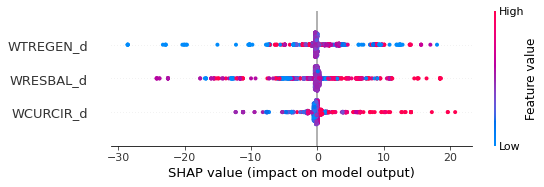

In [139]:
#Shapley values for models on training data
explainer = shap.TreeExplainer(dt_final_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns)

In [140]:
i = 666
print(shap_values[i, :])
print(X_train.iloc[i, :])
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train.iloc[i, :], feature_names=X_train.columns)

[-0.41015179  0.2582211  -0.30950074]
WCURCIR_d   -0.138
WRESBAL_d    2.611
WTREGEN_d   -0.158
Name: 1998-10-21 00:00:00, dtype: float64


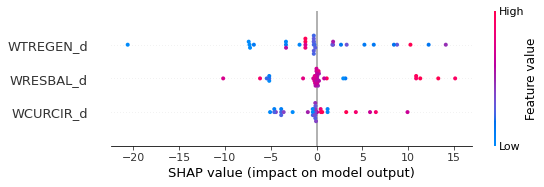

In [141]:
#Shapley values for models on test data
explainer = shap.TreeExplainer(dt_final_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, features=X_test, feature_names=X_train.columns)

In [142]:
i = 25
print(shap_values[i, :])
print(X_train.iloc[i, :])
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train.iloc[i, :], feature_names=X_train.columns)

[-0.14298164 -0.01271896 -0.30573082]
WCURCIR_d    2.438
WRESBAL_d    1.401
WTREGEN_d    0.246
Name: 1986-07-09 00:00:00, dtype: float64


AdaBoost Regressor Prediction Plots

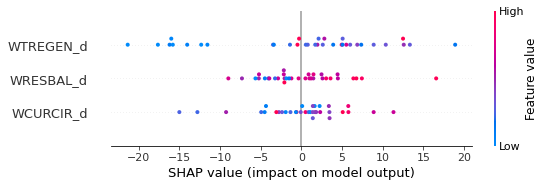

In [143]:
explainer = shap.Explainer(ada_reg.predict, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns)

.values =
array([3.45169748, 4.45235527, 2.63273921])

.base_values =
-0.5756415294305329

.data =
array([  1.032, -17.469,  -1.656])
WCURCIR_d     1.032
WRESBAL_d   -17.469
WTREGEN_d    -1.656
Name: 2022-06-29 00:00:00, dtype: float64


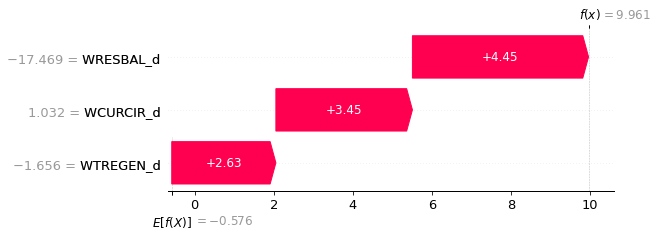

In [144]:
i = 25
print(shap_values[i, :])
print(X_test.iloc[i, :])
shap.plots.waterfall(shap_values[25], max_display=14)

MLP Regressor Prediction Plots

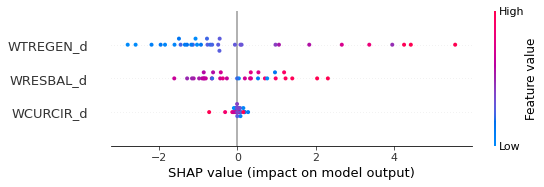

In [145]:
explainer = shap.Explainer(mlp_reg.predict, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns)

.values =
array([-0.00223695, -0.8623467 , -0.76639059])

.base_values =
1.4730850022863735

.data =
array([  1.032, -17.469,  -1.656])
WCURCIR_d     1.032
WRESBAL_d   -17.469
WTREGEN_d    -1.656
Name: 2022-06-29 00:00:00, dtype: float64


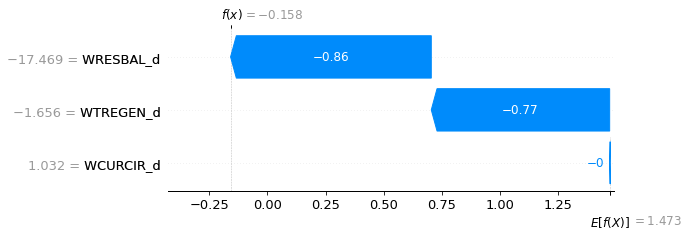

In [146]:
i = 25
print(shap_values[i, :])
print(X_test.iloc[i, :])
shap.plots.waterfall(shap_values[25], max_display=14)